In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/coffee_test_annotations.zip

In [ ]:
# import packages required
import numpy as np
import cv2
from sklearn.cluster import DBSCAN
import os
import glob
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import pandas as pd
import json
import argparse
import re
from collections import defaultdict
from sklearn.cluster import DBSCAN


In [ ]:
if not os.path.exists("lara2018"):
  !git clone https://github.com/esgario/lara2018.git

Cloning into 'lara2018'...
remote: Enumerating objects: 6113, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 6113 (delta 87), reused 115 (delta 54), pack-reused 5950
Receiving objects: 100% (6113/6113), 116.95 MiB | 33.36 MiB/s, done.
Resolving deltas: 100% (538/538), done.
Updating files: 100% (5520/5520), done.


In [ ]:
# Define Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128

COLORS = [[0,0,255], [255,0,0], [100,0,200], [0,190,256]]

annotations_path = "/content/coffee_test_annotations"

In [ ]:
# getting all paths for training and testing
json_path_list = sorted(glob.glob(annotations_path+"/*." + 'json'))
assert len(json_path_list) > 0

In [ ]:
label_color_dict = {
                        "leafrust":[0,0,255],
                        "leafminer":[255,0,0],
                        "freefeeder":[100,0,200],
                        "leafskeletonizer":[0,190,256]
                        }

In [ ]:
"""
img
"""
def calc_area(img, mask, img_name):
  global label_color_dict
  label_color_dict["background_area"] = [0, 0, 0]

  all_areas = {}
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]/255
  leaf_area = img.sum()

  all_areas["image_name"]= img_name
  all_areas["image_height"] = img.shape[0]
  all_areas["image_width"] = img.shape[1]
  all_areas["total_area"] = img.shape[0] * img.shape[1]
  all_areas["leaf_area"] = leaf_area
  health_leaf_area = img.shape[0] * img.shape[1]

  for color in label_color_dict:

    temp_mask = np.all(np.equal(mask, label_color_dict[color]), axis=-1).sum()

    disease_part_area = temp_mask
    health_leaf_area -= disease_part_area
    all_areas[color] = disease_part_area
  all_areas["total_health_leaf_area"] = health_leaf_area

  del label_color_dict["background_area"]

  return all_areas


In [ ]:

def write_csv(filename, data):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

In [ ]:
label_color_dict = {
                        "leafrust":(0,0,255),
                        "leafminer":(255,0,0),
                        "freefeeder":(100,0,200),
                        "leafskeletonizer":(0,190,256)
                        }
def mask_image_from_json(json_file_name):
    global label_color_dict

    with open(json_file_name) as json_file:
        data = json.load(json_file)
        print(data)

    assert data is not None and data["imageData"] is not None

    image_data = np.fromstring(data["imageData"], np.uint8)
    image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

    mask = np.zeros((image.shape[0],image.shape[1],3))

    for shape in data["shapes"]: # Draw polly for each pollygon in the annotation
        label = shape["label"].lower()
        label = re.sub(r'[^a-z0-9]+', '', label)
        fill_color = label_color_dict[label]

        cordiate_array = np.array([shape["points"]],np.int32)
        mask = cv2.fillPoly(mask, cordiate_array, color=fill_color)

    return image, mask

In [ ]:
def dbscan(pixels):
  # Use DBSCAN clustering to cluster the pixels
  deb = True
  dbscan = DBSCAN(eps=7, min_samples=50)
  labels = dbscan.fit_predict(pixels)
  labels = np.logical_not(labels).astype(labels.dtype)
  return labels

# np.fromstring(data["imageData"].decode('base64'), np.uint8)

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        try:
            os.mkdir(path)
        except Exception as e:
            print("Error while creating directory: ", path)
            print("Detail", e)

def start(path):
        # save_dir = make_dir(os.path.join(path,"masks"))
        # json_files = glob.glob(path+"/*.json") # find all .json files in the current directory

        areas = []

        for path in path:
          img, mask = mask_image_from_json(path)
          img = cv2.threshold(dbscan(img), 100, 255, cv2.THRESH_BINARY)[1]
          areas.append(calc_area(img, mask, path.split("/")[-1].split(".")[0]))

        write_csv(areas)

In [ ]:
# print(json_path_list)
print(json_path_list)
start(json_path_list)

['/content/coffee_test_annotations/085931.json', '/content/coffee_test_annotations/085947.json', '/content/coffee_test_annotations/090032.json', '/content/coffee_test_annotations/090104.json', '/content/coffee_test_annotations/090116.json', '/content/coffee_test_annotations/090130.json', '/content/coffee_test_annotations/090139.json', '/content/coffee_test_annotations/090142.json', '/content/coffee_test_annotations/090331.json', '/content/coffee_test_annotations/090349.json', '/content/coffee_test_annotations/090402.json', '/content/coffee_test_annotations/090417.json', '/content/coffee_test_annotations/090430.json', '/content/coffee_test_annotations/090443.json', '/content/coffee_test_annotations/090456.json', '/content/coffee_test_annotations/090506.json', '/content/coffee_test_annotations/090516.json', '/content/coffee_test_annotations/090530.json', '/content/coffee_test_annotations/090553.json', '/content/coffee_test_annotations/090602.json', '/content/coffee_test_annotations/09061

AttributeError: ignored

In [ ]:
def health_leaf_area(y_train_path_list, mask_path_for_disease_area, mask_background_color = [  0,   0,   0]):
  health_percentage_list = []

  for path, mask_path in tqdm( zip(y_train_path_list, mask_path_for_disease_area), total = len(y_train_path_list)):
    img = cv2.imread(path)
    mask = cv2.imread(mask_path)

    mask = mask.reshape(-1, 3)
    colors = np.unique(mask, axis = 0)
    colors  = np.delete(colors, mask_background_color, axis = 0)

    for color in colors:

      img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]/255
      height, width = img.shape

      leaf_area = img.sum()
      temp_mask = mask[mask == color]
      mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)[1]/255
      mask_area = mask.sum()

      health_leaf_percentage = leaf_area/mask_area
      health_percentage_list.append(health_leaf_percentage)

  return health_percentage_list



In [ ]:
import cv2
import numpy as np
import json

def mask_image_from_json(json_file_path):
    with open(json_file_path) as f:
        data = json.load(f)

    image_data = np.fromstring(data["imageData"].decode('base64'), np.uint8)
    # Decode the image using OpenCV
    imgage = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

    img = np.zeros((data["imageHeight"], data["imageWidth"], 3), np.uint8)

    for shape in data['shapes']:
        points = np.array(shape['points'], np.int32)
        points = points.reshape((-1,1,2))
        word = re.sub(r'\W+', '', shape["label"])
        # convert to lowercase
        word = word.lower()
        color = COLOR[word] if len(COLOR[word]) > 0 else np.random.randint(0,255,(1,3)).tolist()[0]
        cv2.fillPoly(img,[points],color)

    return img

NameError: ignored

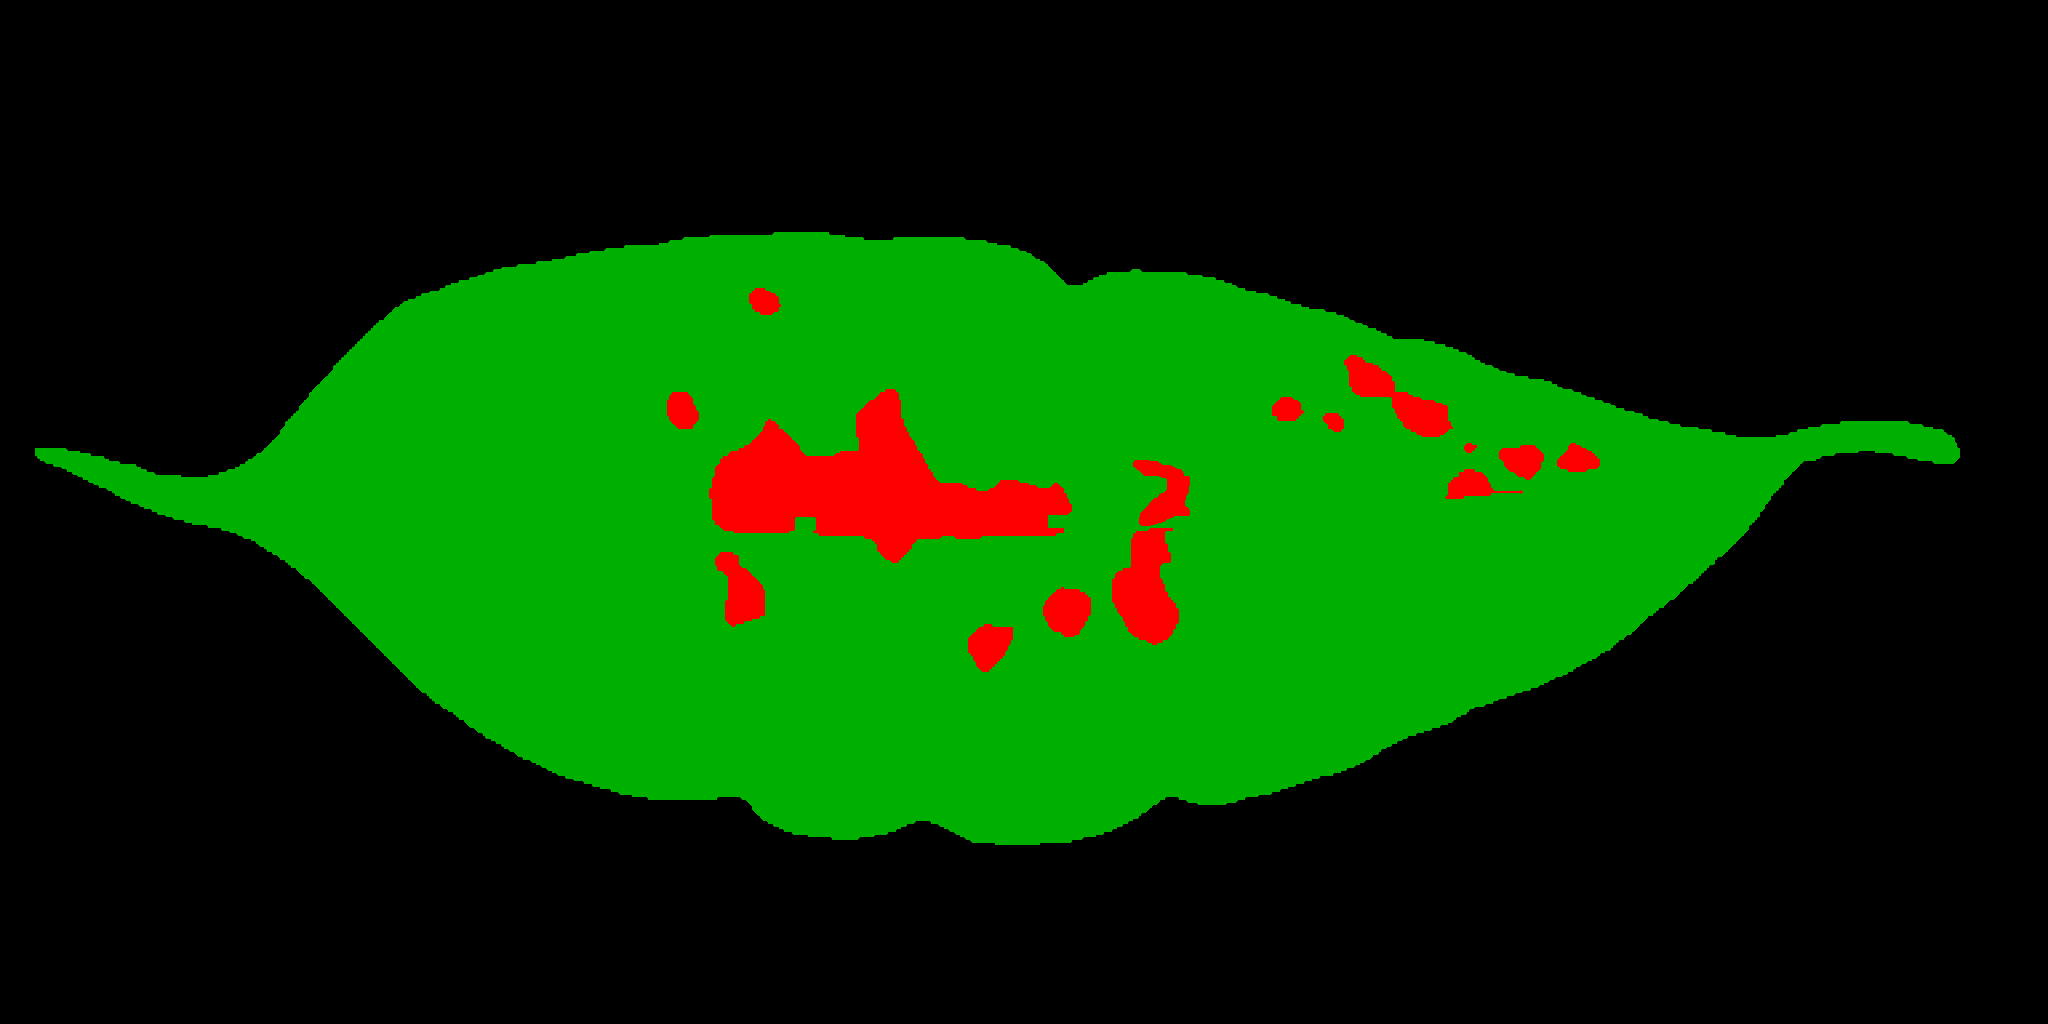

In [ ]:
cv2_imshow(cv2.imread(y_train_path_list[26]))

In [ ]:
import os
import glob
import json
import numpy as np
import cv2 as cv
import pandas as pd
import argparse
from tqdm import tqdm
import re

def make_shapes(path):

    label_color_dict = {
                        "leafrust":(0,0,255),
                        "leafminer":(255,0,0),
                        "freefeeder":(100,0,200),
                        "leafskeletonizer":(0,190,256)
                        }

    if os.path.exists(path):
        save_dir = os.path.join(path,"masks")

        try:
            os.mkdir(save_dir)
        except Exception as e:
            print(e)

        images = []
        masks = []

        json_files = glob.glob(path+"/*.json") # find all .json files in the current directory

        # read the contents of each json file
        for file in tqdm(json_files):
            with open(file) as f:
                data = json.load(f)
                image_path = os.path.join(path,data["imagePath"])

                im = cv2.imread(image_path)
                mask = np.zeros((im.shape[0],im.shape[1],1))

                counter = 0
                for shape in data["shapes"]: # Draw polly for each pollygon in the annotation
                    label = shape["label"].lower()
                    label = re.sub(r'[^a-z0-9]+', '', label)
                    mask = cv2.fillPoly(mask,np.array([shape["points"]],np.int32),color=counter)
                    counter += 1

                images.append(data['imagePath'])

                mask_filename = f"{data['imagePath'].split('.')[0]}_mask.jpg"
                masks.append(os.path.join("masks",mask_filename))

                cv2.imwrite(os.path.join(save_dir,f"{data['imagePath'].split('.')[0]}_mask.jpg"),mask) # save mask to file

            if len(masks) > 0:
                df = pd.DataFrame({'images_names':images,'mask_names':masks})
                df.to_csv(f'{path}/annotations.csv')
    else:
        raise(FileNotFoundError)


# Create the parser object
parser = argparse.ArgumentParser()
# Add an argument
parser.add_argument('--source',type=str,required=True)
# source (path of the directory containing the annotations)
# Parse the argument
args = parser.parse_args()

make_shapes(args.source)

usage: ipykernel_launcher.py [-h] --source SOURCE
ipykernel_launcher.py: error: the following arguments are required: --source


SystemExit: ignored

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
